In [1]:
# library imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Définition du répertoire de travail
repertoire = r"C:\mastere\M2\projet_etude\data\gtfs"
# 2. Chargement des données
df_stops = pd.read_csv(os.path.join(repertoire, 'stops.txt'), sep=',')
df_routes = pd.read_csv(os.path.join(repertoire, 'routes.txt'), sep=',')
df_trips = pd.read_csv(os.path.join(repertoire, 'trips.txt'), sep=',')
df_stop_times = pd.read_csv(os.path.join(repertoire, 'stop_times.txt'), sep=',')
df_shapes = pd.read_csv(os.path.join(repertoire, 'shapes.txt'), sep=',')
df_calendar = pd.read_csv(os.path.join(repertoire, 'calendar.txt'), sep=',')
df_agency = pd.read_csv(os.path.join(repertoire, 'agency.txt'), sep=',')
df_calendar_dates = pd.read_csv(os.path.join(repertoire, 'calendar_dates.txt'), sep=',')

In [3]:
# Étape 1 : Fusion stop_times + trips
df_merged = df_stop_times.merge(df_trips[['trip_id', 'route_id', 'service_id']], on='trip_id', how='left')

# Étape 2 : Ajout de la route
df_merged = df_merged.merge(df_routes[['route_id', 'route_short_name', 'route_long_name']], on='route_id', how='left')

# Étape 3 : Ajout des arrêts
df_merged = df_merged.merge(df_stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']], on='stop_id', how='left')

# Étape 4 : Nettoyage de l’heure
df_merged['arrival_time'] = pd.to_datetime(df_merged['arrival_time'], errors='coerce', format='%H:%M:%S')

# Supprimer les lignes sans heure valide
df_merged = df_merged.dropna(subset=['arrival_time'])

In [4]:
df_merged.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled,stop_headsign,route_id,service_id,route_short_name,route_long_name,stop_name,stop_lat,stop_lon
0,520015,1900-01-01 16:29:00,16:29:00,21487,1,0,0,0,NaN,232,1,33,Chauvigny Mairie-Gare Routière,Paul Rebeilleau,46.571533,0.372197
1,520015,1900-01-01 16:30:35,16:30:35,20651,2,0,0,575,NaN,232,1,33,Chauvigny Mairie-Gare Routière,Rabelais,46.569885,0.379253
2,520015,1900-01-01 16:32:18,16:32:18,20837,3,0,0,1196,NaN,232,1,33,Chauvigny Mairie-Gare Routière,Maison des Etudiants,46.568075,0.386888
3,520015,1900-01-01 16:36:00,16:36:00,20451,4,0,0,2524,NaN,232,1,33,Chauvigny Mairie-Gare Routière,Tour Jean Bernard,46.560340,0.387059
4,520015,1900-01-01 16:45:00,16:45:00,20570,5,0,0,5428,NaN,232,1,33,Chauvigny Mairie-Gare Routière,Eglise Mignaloux,46.544201,0.414621


In [5]:
# Variables temporelles
df_merged['hour'] = df_merged['arrival_time'].dt.hour
df_merged['minute'] = df_merged['arrival_time'].dt.minute
df_merged['time_of_day'] = pd.cut(df_merged['hour'],
                                  bins=[-1, 5, 9, 15, 19, 24],
                                  labels=['nuit', 'matin', 'midi', 'soirée', 'nuit_tardive'])

# Simulation du jour de la semaine pour l'exemple
df_merged['day_of_week'] = np.random.choice(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], size=len(df_merged))
df_merged['is_weekend'] = df_merged['day_of_week'].isin(['Samedi', 'Dimanche'])


In [6]:
# Simulation simple basée sur l'heure
def simuler_affluence(row):
    if row['hour'] in range(7, 10) or row['hour'] in range(17, 20):
        return np.random.poisson(50)  # heures de pointe
    elif row['is_weekend']:
        return np.random.poisson(15)  # week-end
    else:
        return np.random.poisson(25)  # heures creuses

df_merged['affluence'] = df_merged.apply(simuler_affluence, axis=1)


In [7]:
df_model = df_merged[[
    'stop_id', 'route_id', 'hour', 'minute', 'time_of_day',
    'day_of_week', 'is_weekend', 'affluence'
]]


In [8]:
df_model_encoded = pd.get_dummies(df_model, columns=['stop_id', 'route_id', 'time_of_day', 'day_of_week'], drop_first=True)


In [9]:
# %pip install scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [10]:
# 1. Séparation X / y
X = df_model_encoded.drop('affluence', axis=1)
y = df_model_encoded['affluence']

In [11]:
# 2. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# 3. Entraînement du modèle
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

In [13]:
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42)

In [14]:
# 4. Prédictions
y_pred = rf.predict(X_test)

In [16]:
# 5. Évaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE : {rmse:.2f}")
print(f"✅ R² : {r2:.2f}")


✅ RMSE : 5.79
✅ R² : 0.86


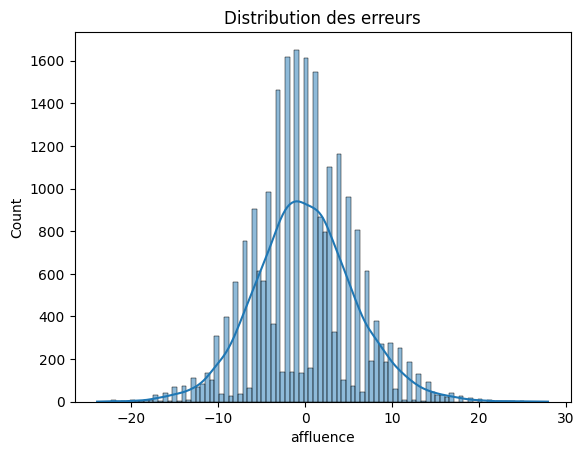

In [17]:
preds = rf.predict(X_test)
errors = y_test - preds
sns.histplot(errors, kde=True)
plt.title("Distribution des erreurs")
plt.show()


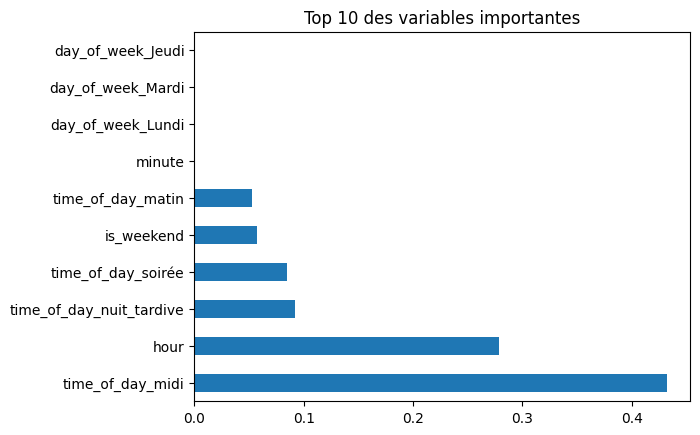

In [18]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 des variables importantes")
plt.show()
